In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import warnings

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Load the dataset
df = pd.read_csv('/app/data/sensor_data.csv', parse_dates=['timestamp'])

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Dataset loaded successfully!
Shape: (9000, 6)
Columns: ['sensor_id', 'sensor_type', 'value', 'unit', 'timestamp', 'quality']


In [3]:
# Basic information about the dataset
print("=== Dataset Info ===")
df.info()

print("\n=== Statistical Summary ===")
print(df.describe())

# Check unique values
print("=== Sensor Types ===")
print(df['sensor_type'].value_counts())

print("\n=== Unique Sensors ===")
print(f"Total unique sensors: {df['sensor_id'].nunique()}")
print(df['sensor_id'].value_counts().head(5))

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   sensor_id    9000 non-null   object             
 1   sensor_type  9000 non-null   object             
 2   value        9000 non-null   float64            
 3   unit         9000 non-null   object             
 4   timestamp    9000 non-null   datetime64[ns, UTC]
 5   quality      9000 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 422.0+ KB

=== Statistical Summary ===
             value      quality
count  9000.000000  9000.000000
mean     55.424294     0.978346
std      17.286618     0.017304
min      12.816000     0.905000
25%      38.257750     0.966000
50%      58.100000     0.980000
75%      71.350500     0.993000
max      83.193000     1.000000
=== Sensor Types ===
sensor_type
pressure     

In [4]:
# Check for missing values
print("=== Missing Values Analysis ===")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

for col in df.columns:
    if missing_data[col] > 0:
        print(f"{col}: {missing_data[col]} ({missing_percentage[col]:.2f}%)")

# Handle missing values
if df['value'].isna().sum() / len(df) < 0.05:
    print("\nMissing data < 5%, imputing with mean...")
    df['value'].fillna(df['value'].mean(), inplace=True)
else:
    print("\nMissing data >= 5%, dropping rows...")
    df.dropna(subset=['value'], inplace=True)

print(f"Final dataset shape: {df.shape}")

=== Missing Values Analysis ===

Missing data < 5%, imputing with mean...
Final dataset shape: (9000, 6)


Creating EDA plots...



Plots saved to: /app/docs/ml/eda_preview.png


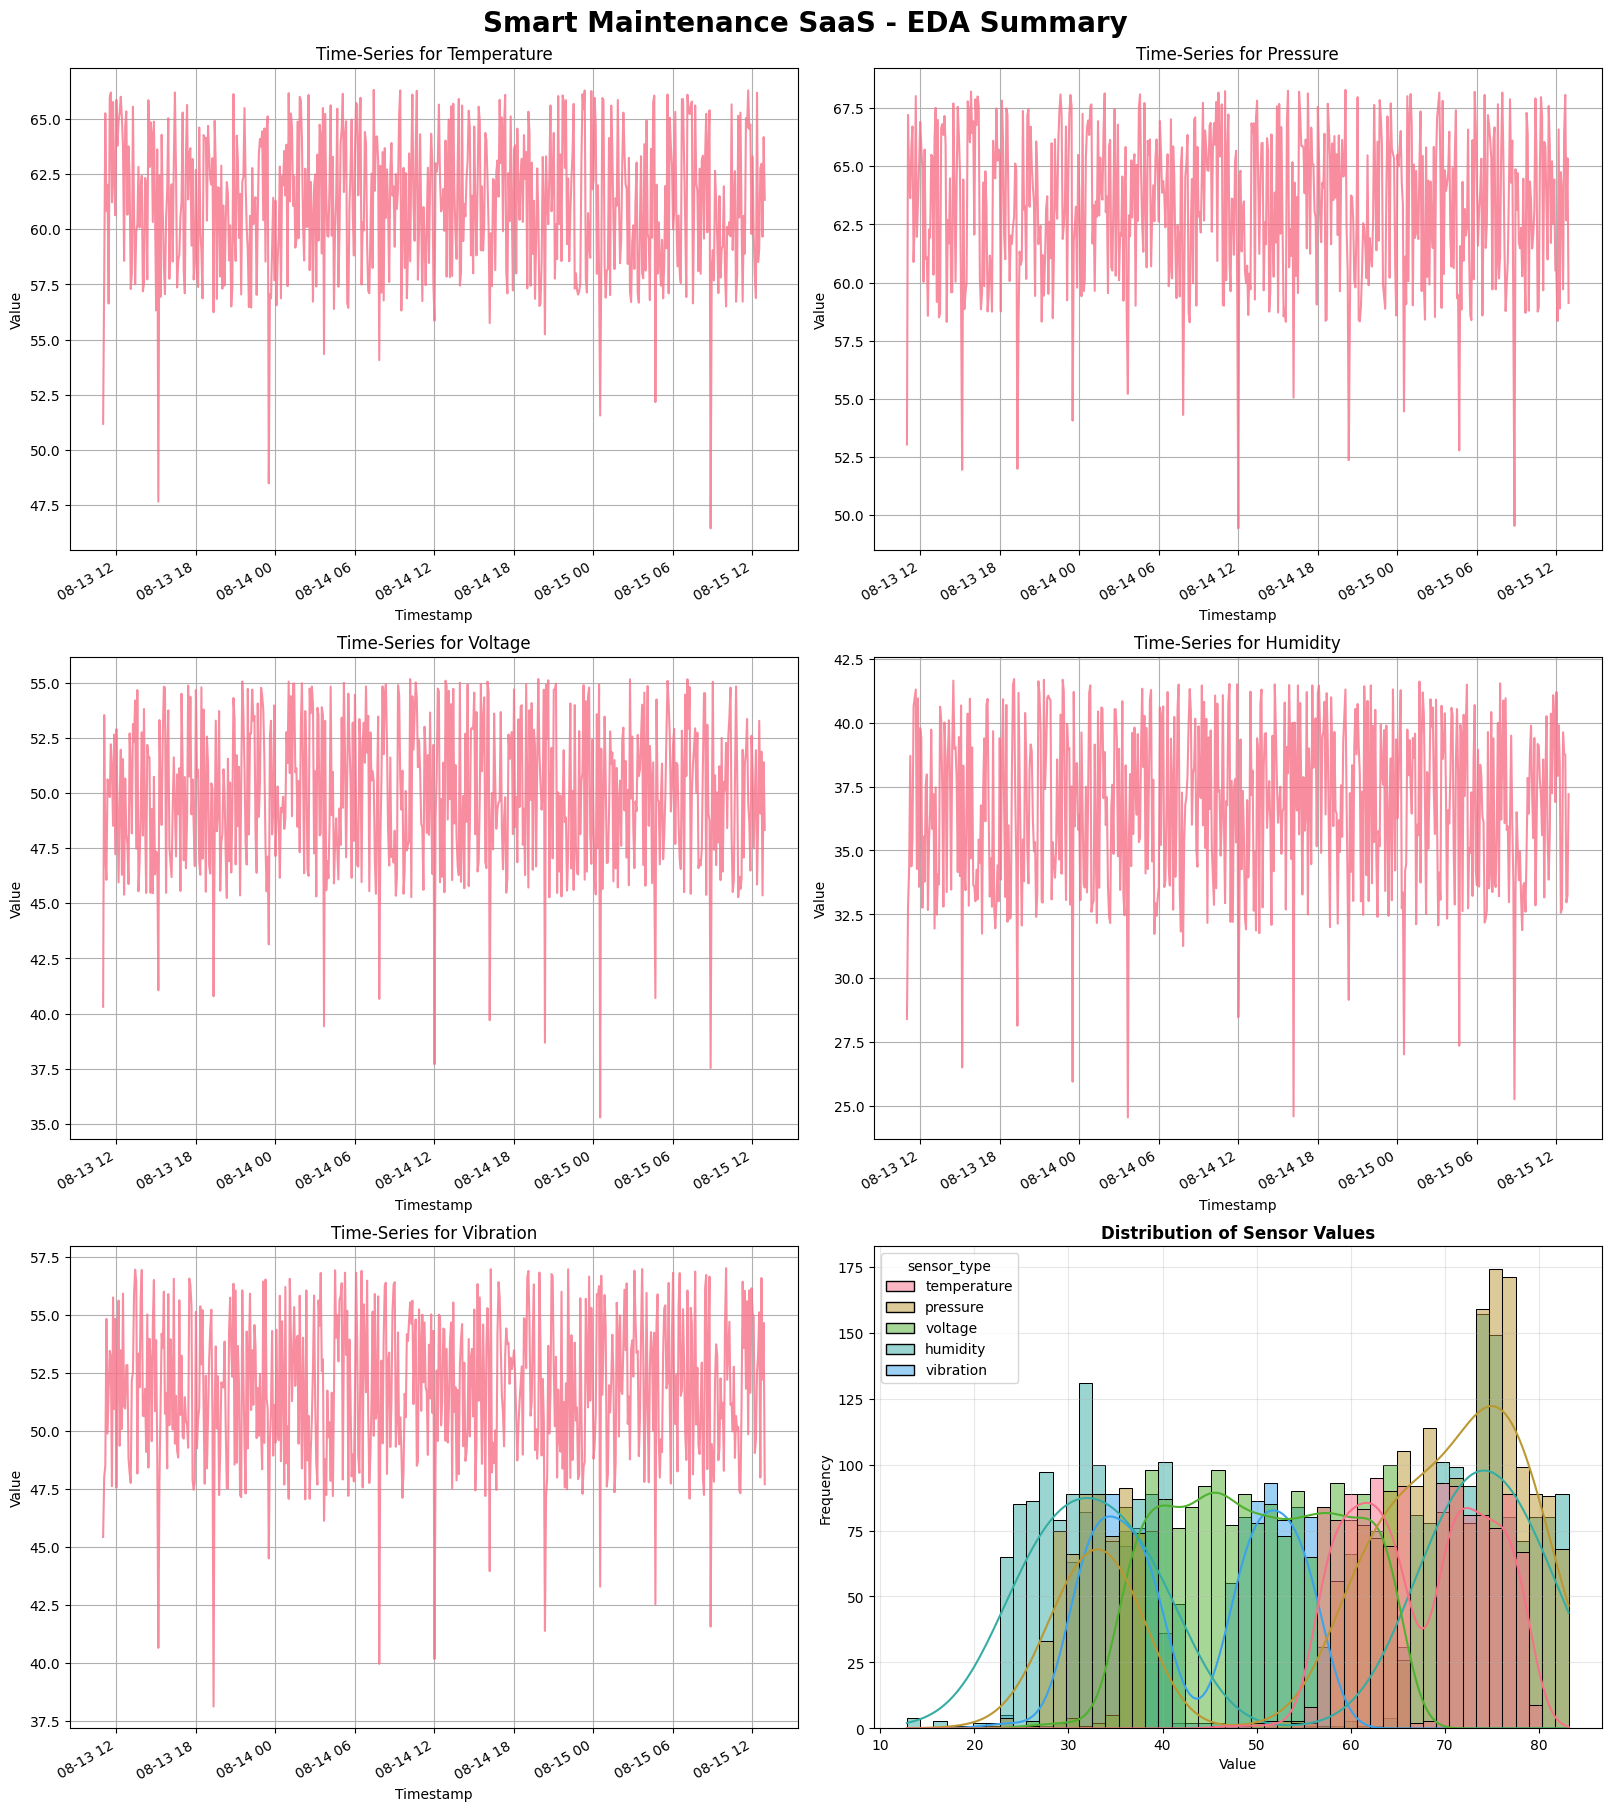

In [5]:
# Create a more insightful grid of plots
print("Creating EDA plots...")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18), constrained_layout=True)
fig.suptitle('Smart Maintenance SaaS - EDA Summary', fontsize=20, fontweight='bold')

# Flatten axes array for easy iteration
ax_flat = axes.flatten()

# Plot 1-5: Time-series for each sensor type on its own subplot
sensor_types = df['sensor_type'].unique()
for i, sensor_type in enumerate(sensor_types):
    ax = ax_flat[i]
    subset = df[df['sensor_type'] == sensor_type].set_index('timestamp')
    # Plot all data for one sensor of this type for clarity
    first_sensor_id = subset['sensor_id'].iloc[0]
    subset[subset['sensor_id'] == first_sensor_id]['value'].plot(ax=ax, title=f'Time-Series for {sensor_type.capitalize()}', grid=True, alpha=0.8)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Value')

# Plot 6: Value distribution histogram for all data
ax = ax_flat[5]
sns.histplot(data=df, x='value', hue='sensor_type', ax=ax, bins=50, kde=True)
ax.set_title('Distribution of Sensor Values', fontweight='bold')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.grid(True, alpha=0.3)

# Save the plot
output_path = '/app/docs/ml/eda_preview.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nPlots saved to: {output_path}")
plt.show()

In [6]:
# Perform ADF test on sensor-001
print("=== Augmented Dickey-Fuller Test Results ===")

sensor_001_data = df[df['sensor_id'] == 'sensor-001']['value'].dropna()

if len(sensor_001_data) > 0:
    result = adfuller(sensor_001_data)
    
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")
    
    if result[1] <= 0.05:
        print("\nResult: Series is stationary (reject null hypothesis)")
    else:
        print("\nResult: Series is non-stationary (fail to reject null hypothesis)")
else:
    print("No data available for sensor-001 to perform ADF test")

=== Augmented Dickey-Fuller Test Results ===
ADF Statistic: -24.113235
p-value: 0.000000
Critical Values:
  1%: -3.441
  5%: -2.866
  10%: -2.569

Result: Series is stationary (reject null hypothesis)


In [7]:
# Test other sensors too
print("\n=== ADF Test Summary for All Sensor Types ===")
for sensor_type in df['sensor_type'].unique():
    sensor_data = df[df['sensor_type'] == sensor_type]['value'].dropna()
    if len(sensor_data) > 10:
        try:
            result = adfuller(sensor_data)
            is_stationary = result[1] <= 0.05
            status = "Stationary" if is_stationary else "Non-stationary"
            print(f"{sensor_type}: {status} (p-value: {result[1]:.4f})")
        except Exception as e:
            print(f"{sensor_type}: Error - {str(e)}")
    else:
        print(f"{sensor_type}: Insufficient data")


=== ADF Test Summary for All Sensor Types ===
temperature: Non-stationary (p-value: 0.6743)
pressure: Non-stationary (p-value: 0.3880)
voltage: Non-stationary (p-value: 0.6167)
humidity: Non-stationary (p-value: 0.6222)
vibration: Non-stationary (p-value: 0.5364)


In [8]:
# Final summary
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS SUMMARY")
print("="*60)

print(f"\n📊 Dataset Overview:")
print(f"   • Total records: {len(df):,}")
print(f"   • Unique sensors: {df['sensor_id'].nunique()}")
print(f"   • Sensor types: {df['sensor_type'].nunique()} ({', '.join(df['sensor_type'].unique())})")
print(f"   • Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")

print(f"\n🔍 Data Quality:")
print(f"   • Missing values: {df.isnull().sum().sum()}")
print(f"   • Average quality score: {df['quality'].mean():.3f}")
print(f"   • Low quality records (<0.9): {(df['quality'] < 0.9).sum()} ({(df['quality'] < 0.9).mean()*100:.1f}%)")

print(f"\n📈 Value Statistics:")
print(f"   • Value range: {df['value'].min():.2f} to {df['value'].max():.2f}")
print(f"   • Mean value: {df['value'].mean():.2f}")
print(f"   • Standard deviation: {df['value'].std():.2f}")

print(f"\n📁 Output Files:")
print(f"   • EDA plots saved: docs/ml/eda_preview.png")
print(f"   • Analysis complete and ready for feature engineering")

print("\n" + "="*60)
print("EDA COMPLETE - Ready for model development!")
print("="*60)


EXPLORATORY DATA ANALYSIS SUMMARY

📊 Dataset Overview:
   • Total records: 9,000
   • Unique sensors: 15
   • Sensor types: 5 (temperature, pressure, voltage, humidity, vibration)
   • Time range: 2025-08-13 11:00:48.746689+00:00 to 2025-08-15 12:55:48.746689+00:00

🔍 Data Quality:
   • Missing values: 0
   • Average quality score: 0.978
   • Low quality records (<0.9): 0 (0.0%)

📈 Value Statistics:
   • Value range: 12.82 to 83.19
   • Mean value: 55.42
   • Standard deviation: 17.29

📁 Output Files:
   • EDA plots saved: docs/ml/eda_preview.png
   • Analysis complete and ready for feature engineering

EDA COMPLETE - Ready for model development!
